
# **Retail Customer Segmentation (K‑Means)**

**Goal:** Use **K‑Means** to cluster customers by behavior, choose K via **Elbow method**, and visualize with **PCA**.  
Dataset: https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset



## ✅ Requirements Recap
- Data preprocessing
- Determine optimal K (**Elbow**)
- Apply **K‑Means**
- **Visualize** clusters (PCA 2‑D)



## 🔧 Setup & Data
- If using Kaggle CLI, run the (commented) shell below. Otherwise, download the CSV manually and set the path.


In [8]:
# Task 2 — Retail Customer Segmentation (K-Means)
import os, warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Point to your file (XLSX given by org or CSV). We'll auto-handle either.
DATA_PATH = "data/Online Retail.xlsx"   # change if needed
CSV_OUT   = "data/retail_input.csv"     # we'll export CSV here if source is xlsx

# ---- Load & (if needed) convert XLSX -> CSV ----
if DATA_PATH.lower().endswith((".xlsx", ".xls")):
    xls = pd.ExcelFile(DATA_PATH)
    # If multiple sheets, take the first non-empty
    for sh in xls.sheet_names:
        df = pd.read_excel(xls, sh)
        if len(df) > 0:
            break
    df.to_csv(CSV_OUT, index=False)
    src_csv = CSV_OUT
else:
    src_csv = DATA_PATH

df = pd.read_csv(src_csv)
print("Loaded:", src_csv, "| shape:", df.shape)
print("Columns:", list(df.columns))


Loaded: data/retail_input.csv | shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [9]:
# Two common schemas:
# A) Mall_Customers: columns like ["Age","Annual Income (k$)","Spending Score (1-100)"]
# B) Online Retail (UCI-like): ["InvoiceNo","StockCode","Description","Quantity","InvoiceDate","UnitPrice","CustomerID","Country"]
from pandas.api.types import is_datetime64_any_dtype as is_dt

def has_cols(cols): 
    return all(c in df.columns for c in cols)

if has_cols(["Age"]) or any("Spending Score" in c for c in df.columns):
    # ---- Mall Customers style ----
    # keep canonical numeric columns (robust to slight name changes)
    col_map = {}
    for c in df.columns:
        cl = c.lower()
        if "age" in cl: col_map["Age"] = c
        if "annual" in cl or "income" in cl: col_map["AnnualIncome"] = c
        if "spending" in cl: col_map["SpendingScore"] = c
    use = [col_map[k] for k in ["Age","AnnualIncome","SpendingScore"] if k in col_map]
    feat = df[use].dropna().copy()
    feat.columns = ["Age","AnnualIncome","SpendingScore"]
    dataset_type = "mall"
else:
    # ---- Online Retail style -> RFM per CustomerID ----
    # Clean + RFM features: Recency (days), Frequency (# invoices), Monetary (sum)
    tmp = df.copy()
    # ensure datetime
    if "InvoiceDate" in tmp.columns and not is_dt(tmp["InvoiceDate"]):
        tmp["InvoiceDate"] = pd.to_datetime(tmp["InvoiceDate"], errors="coerce")
    # remove rows without CustomerID and negative quantities (returns)
    if "CustomerID" in tmp.columns:
        tmp = tmp.dropna(subset=["CustomerID"]).copy()
    if "Quantity" in tmp.columns:
        tmp = tmp[tmp["Quantity"] > 0].copy()
    # compute monetary
    if {"Quantity","UnitPrice"} <= set(tmp.columns):
        tmp["Amount"] = tmp["Quantity"] * tmp["UnitPrice"]
    else:
        tmp["Amount"] = 0.0

    max_date = tmp["InvoiceDate"].max()
    ref_date = (max_date if pd.notna(max_date) else pd.Timestamp.today()) + pd.Timedelta(days=1)

    # frequency = distinct invoices; recency = days since last purchase; monetary = sum amount
    grp = tmp.groupby("CustomerID")
    recency   = (ref_date - grp["InvoiceDate"].max()).dt.days.rename("Recency")
    frequency = grp["InvoiceNo"].nunique().rename("Frequency") if "InvoiceNo" in tmp.columns else grp.size().rename("Frequency")
    monetary  = grp["Amount"].sum().rename("Monetary")
    feat = pd.concat([recency, frequency, monetary], axis=1).dropna()
    # remove extreme zeros/negatives
    feat = feat[(feat["Monetary"] > 0) & (feat["Frequency"] > 0)]
    dataset_type = "retail_rfm"

print("Feature sample:")
display(feat.head())


Feature sample:


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(feat.values)
feature_names = list(feat.columns)
print("Features used:", feature_names, "| scaled shape:", Xs.shape)


Features used: ['Recency', 'Frequency', 'Monetary'] | scaled shape: (4338, 3)


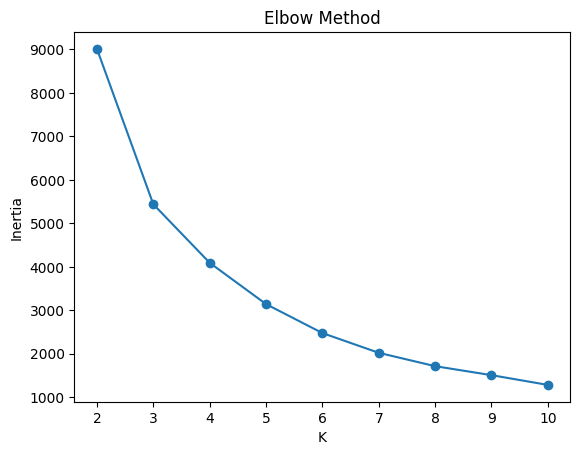

Tip: pick K at the 'bend' (often 4–6).


In [11]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Ks, inertias = list(range(2, 11)), []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(Xs)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(Ks, inertias, marker="o")
plt.title("Elbow Method")
plt.xlabel("K"); plt.ylabel("Inertia")
plt.show()

print("Tip: pick K at the 'bend' (often 4–6).")


In [12]:
K_FINAL = 5  # set from elbow
kmeans = KMeans(n_clusters=K_FINAL, random_state=RANDOM_STATE, n_init=20)
labels = kmeans.fit_predict(Xs)

seg = feat.copy()
seg["cluster"] = labels
display(seg["cluster"].value_counts().sort_index())


cluster
0     213
1       6
2    1061
3    3050
4       8
Name: count, dtype: int64

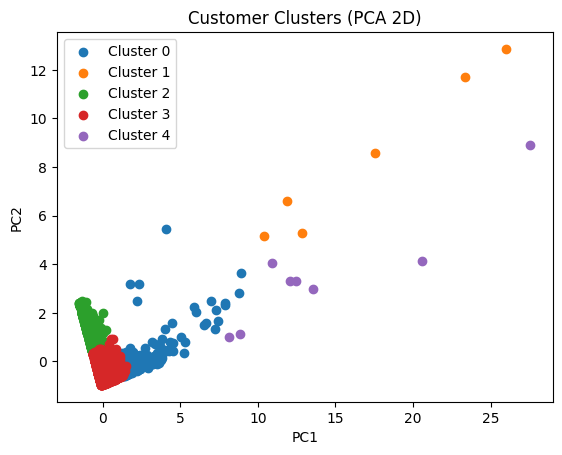

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=2, random_state=RANDOM_STATE)
XY = pca.fit_transform(Xs)

plt.figure()
for lab in np.unique(labels):
    pts = XY[labels==lab]
    plt.scatter(pts[:,0], pts[:,1], label=f"Cluster {lab}")
plt.title("Customer Clusters (PCA 2D)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.show()


In [14]:
# numeric profile by cluster
profile = seg.groupby("cluster").mean(numeric_only=True)
display(profile.round(2))

# Save labeled data and artifacts
os.makedirs("outputs", exist_ok=True)
os.makedirs("models", exist_ok=True)
seg.to_csv("outputs/task2_clusters.csv", index=False)

# (optional) persist model + scaler for deploy
import joblib, json
joblib.dump(kmeans, "models/task2_kmeans.joblib")
joblib.dump(scaler, "models/task2_scaler.joblib")
with open("models/task2_feature_names.json","w") as f:
    json.dump({"features": feature_names, "dataset_type": dataset_type}, f)

print("Saved: outputs/task2_clusters.csv and models/*.joblib")


,Recency,Frequency,Monetary
cluster,,,
0,15.67,21.29,12831.74
1,7.67,43.00,190863.46
2,248.66,1.55,478.19
3,43.99,3.65,1338.75
4,6.50,120.62,55312.69


Saved: outputs/task2_clusters.csv and models/*.joblib
